# **Importing Modules and Libraries**

In [494]:
# importing required libraries
# Colab-ready: rút gọn theo base tác giả (binary only)
# Nội dung: preprocess, visuals (pie), feature selection (corr), 
# Kịch bản1: RF (sample 10k) 
# Kịch bản2: Occlusion (drop TTL) 
# Kịch bản3: Time compare DT vs RF
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

# **Importing Datasets**

In [495]:
df = pd.read_csv('UNSW_NB15.csv')

In [496]:
print("Trước khi làm sạch:", df.shape)


Trước khi làm sạch: (175341, 45)


In [497]:
# ---------- CẤU HÌNH ----------
  # <-- chỉnh đường dẫn tới file CSV của bạn
SAMPLE_N = None                        # sample size để giảm chi phí tính toán (None để dùng toàn bộ) 10000
RANDOM_STATE = 42
TOP_CORR_THRESHOLD = 0.3                # ngưỡng chọn feature theo |corr| với label
TOP_K_FEATURES = 15                     # hoặc chọn top-k nếu muốn

# **LABEL ENCODE**

In [498]:
# Các dataset UNSW-thường có cột 'label' (0 normal, 1 attack) và 'attack_cat'
label_col = None
for cand in ['label','Label','class']:
    if cand in df.columns:
        label_col = cand
        break

if label_col is None:
    raise ValueError("Không tìm thấy cột label ('label'/'Label'/'class') trong dataset. Hãy kiểm tra tên cột.")

In [499]:
# map 0 -> 'normal', else -> 'abnormal' (dùng cho pie chart)
df['label_text'] = df[label_col].map(lambda x: 'normal' if int(x)==0 else 'abnormal')

# ensure binary numeric label (0/1)
df['y_binary'] = df[label_col].apply(lambda x: 0 if int(x)==0 else 1)

## **TIỀN XỬ LÍ**

In [500]:
# Thay giá trị '-' trong cột 'service' bằng NaN (theo paper)
if 'service' in df.columns:
    df['service'].replace('-', np.nan, inplace=True)

C:\Users\asus\AppData\Local\Temp\ipykernel_15864\1640883425.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['service'].replace('-', np.nan, inplace=True)


Sau dropna/dropdup: (81173, 47)


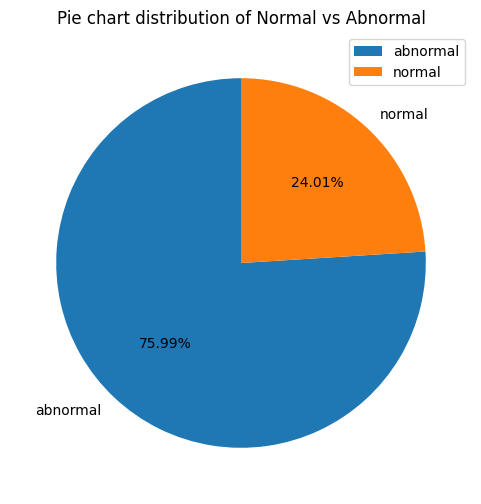

Có cột 'attack_cat' (multi-class), nhưng nhóm chỉ thực hiện Binary Classification → bỏ qua biểu đồ này.


In [501]:
# ---------- CLEAN: drop duplicates & NA ----------
df = df.drop_duplicates().dropna()
print("Sau dropna/dropdup:", df.shape)
# ---------- VISUAL: Pie charts ----------
plt.figure(figsize=(6,6))
plt.pie(df['label_text'].value_counts(), labels=df['label_text'].value_counts().index, autopct='%0.2f%%', startangle=90)
plt.title("Pie chart distribution of Normal vs Abnormal")
plt.legend()
plt.show()

if 'attack_cat' in df.columns:
    print("Có cột 'attack_cat' (multi-class), nhưng nhóm chỉ thực hiện Binary Classification → bỏ qua biểu đồ này.")
    # skip plotting
else:
    print("Không tìm thấy 'attack_cat' (multi-class) — bỏ qua biểu đồ multi-class.")

In [502]:
# ---------- Prepare features: drop meta columns ----------
drop_cols = []
for c in ['id', 'label', label_col, 'label_text', 'y_binary', 'attack_cat']:
    if c in df.columns:
        drop_cols.append(c)

X_all = df.drop(columns=drop_cols, errors='ignore')
y_all = df['y_binary']

print("Số feature trước encode:", X_all.shape[1])

Số feature trước encode: 42


In [503]:
# ---------- ENCODE categorical bằng LabelEncoder ----------
cat_cols = X_all.select_dtypes(include=['object','category']).columns.tolist()
print("Categorical columns:", cat_cols[:30])
le_dict = {}
for c in cat_cols:
    le = LabelEncoder()
    X_all[c] = le.fit_transform(X_all[c].astype(str))
    le_dict[c] = le

Categorical columns: ['proto', 'service', 'state']


In [504]:
# ✅ In số feature sau khi encode
print("Số feature sau encode:", X_all.shape[1])

Số feature sau encode: 42


## **FEATURE SELECTION**

In [505]:
# ---------- Feature selection bằng Pearson correlation với label ----------
# Đảm bảo cột numeric để corr()
df_corr_ready = pd.concat([X_all, y_all.rename('label')], axis=1)
corr_mat = df_corr_ready.corr()
corr_with_label = corr_mat['label'].abs().sort_values(ascending=False)
# Bỏ chính nó (label)
corr_with_label = corr_with_label.drop('label', errors='ignore')

In [506]:
# Chọn feature theo threshold hoặc top-k (ưu tiên threshold nếu có)
selected_by_thresh = corr_with_label[corr_with_label >= TOP_CORR_THRESHOLD]
if len(selected_by_thresh) >= 1:
    selected_features = selected_by_thresh.index.tolist()
    print(f"Chọn theo ngưỡng |corr| >= {TOP_CORR_THRESHOLD}: {len(selected_features)} features")
else:
    selected_features = corr_with_label.head(TOP_K_FEATURES).index.tolist()
    print(f"Không có feature nào >= {TOP_CORR_THRESHOLD}. Chọn top-{TOP_K_FEATURES} theo corr.")

print("Selected features:", selected_features)

Chọn theo ngưỡng |corr| >= 0.3: 13 features
Selected features: ['ct_state_ttl', 'sttl', 'state', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_srv_src', 'ct_srv_dst', 'ct_src_dport_ltm', 'ct_dst_ltm', 'ct_src_ltm', 'rate', 'dload', 'sload']


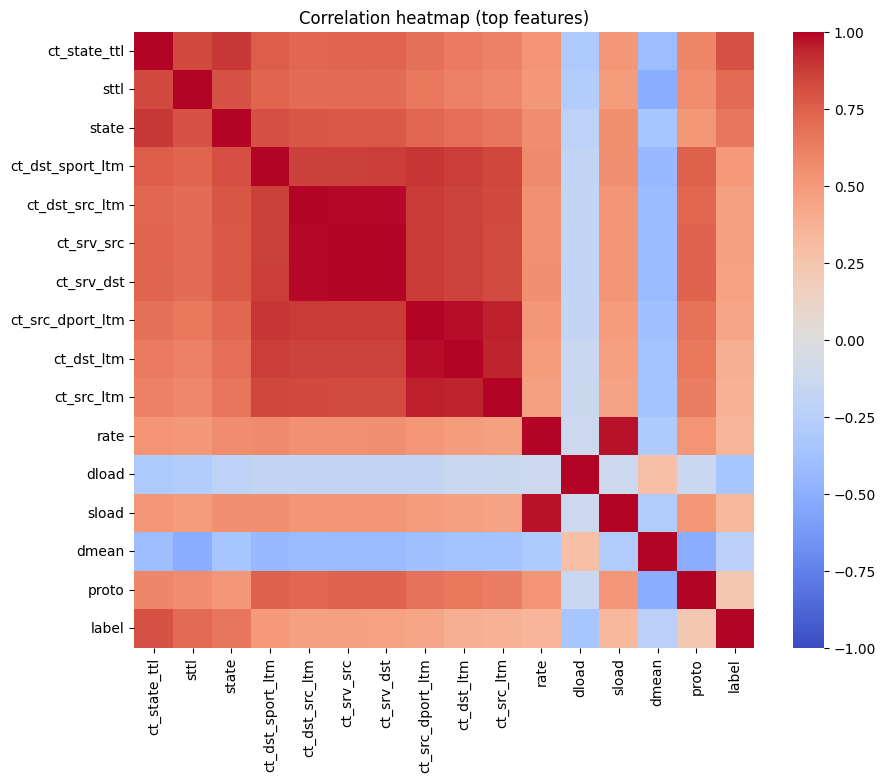

In [507]:
# Hiện heatmap top features (nếu nhiều thì lấy top 15)
top_for_heatmap = corr_with_label.head(15).index.tolist()
plt.figure(figsize=(10,8))
sns.heatmap(df_corr_ready[top_for_heatmap + ['label']].corr(), cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation heatmap (top features)")
plt.show()

## **TRAIN MÔ HÌNH**

In [508]:
# ---------- Sample nếu cần ----------
if SAMPLE_N is not None and SAMPLE_N < len(X_all):
    X_sel, _, y_sel, _ = train_test_split(X_all[selected_features], y_all, train_size=SAMPLE_N, stratify=y_all, random_state=RANDOM_STATE)
else:
    X_sel = X_all[selected_features]
    y_sel = y_all

In [509]:
# ---------- Scaling (StandardScaler) ----------
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X_sel), columns=X_sel.columns)


In [510]:
# ---------- Train/test split ----------
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_sel, test_size=0.2, stratify=y_sel, random_state=RANDOM_STATE)
print("Train/Test sizes:", X_train.shape, X_test.shape)
print("Tỉ lệ attack trong train:", y_train.mean())

Train/Test sizes: (64938, 13) (16235, 13)
Tỉ lệ attack trong train: 0.7599248513967168


In [511]:
# ---------- Utility train + eval ----------
def train_and_eval(model, X_tr, y_tr, X_te, y_te):
    t0 = time.time()
    model.fit(X_tr, y_tr)
    t_time = time.time() - t0
    y_pred = model.predict(X_te)
    acc = accuracy_score(y_te, y_pred)
    return {'model': model, 'train_time_s': t_time, 'accuracy': acc, 'report': classification_report(y_te, y_pred, digits=4)}

## **Kịch bản 1**

In [512]:
# ---------------- Kịch bản 1: RandomForest (baseline) ----------------
rf = RandomForestClassifier(n_estimators=100, random_state=RANDOM_STATE, n_jobs=-1)
res_rf = train_and_eval(rf, X_train, y_train, X_test, y_test)
print("\n[RF baseline] time=%.3fs, acc=%.4f" % (res_rf['train_time_s'], res_rf['accuracy']))
print(res_rf['report'])




[RF baseline] time=1.004s, acc=0.9846
              precision    recall  f1-score   support

           0     0.9787    0.9566    0.9676      3898
           1     0.9864    0.9934    0.9899     12337

    accuracy                         0.9846     16235
   macro avg     0.9826    0.9750    0.9787     16235
weighted avg     0.9846    0.9846    0.9845     16235



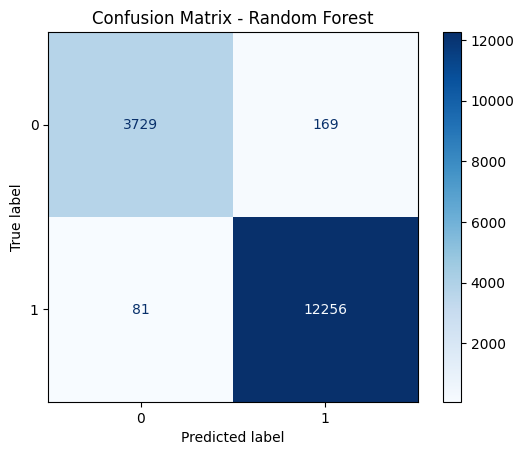

In [513]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = res_rf['model'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()


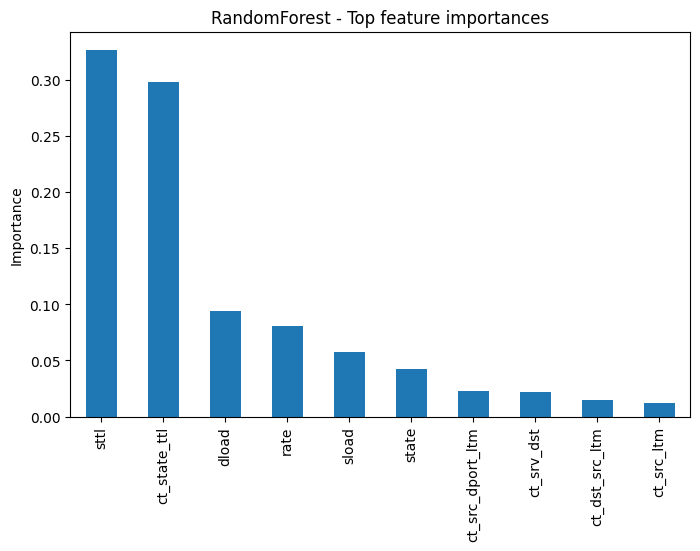

In [514]:
# Feature importance bar chart (top 10)
fi = pd.Series(res_rf['model'].feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
fi.head(10).plot(kind='bar')
plt.title("RandomForest - Top feature importances")
plt.ylabel("Importance")
plt.show()

In [515]:
#DT
# Decision Tree (giới hạn độ sâu = 10)
dt = DecisionTreeClassifier(max_depth=10, random_state=42)

res_dt = train_and_eval(dt, X_train, y_train, X_test, y_test)
print("\n[Decision Tree baseline] time=%.3fs, acc=%.4f" % (res_dt['train_time_s'], res_dt['accuracy']))
print(res_dt['report'])




[Decision Tree baseline] time=0.284s, acc=0.9797
              precision    recall  f1-score   support

           0     0.9755    0.9389    0.9569      3898
           1     0.9809    0.9925    0.9867     12337

    accuracy                         0.9797     16235
   macro avg     0.9782    0.9657    0.9718     16235
weighted avg     0.9796    0.9797    0.9795     16235



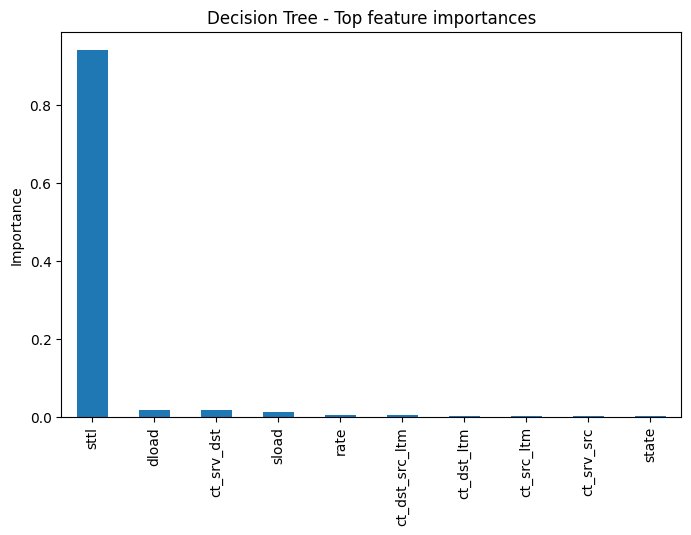

In [516]:
# Feature importance bar chart (top 10)
fii = pd.Series(res_dt['model'].feature_importances_, index=X_train.columns).sort_values(ascending=False)
plt.figure(figsize=(8,5))
fii.head(10).plot(kind='bar')
plt.title("Decision Tree - Top feature importances")
plt.ylabel("Importance")
plt.show()

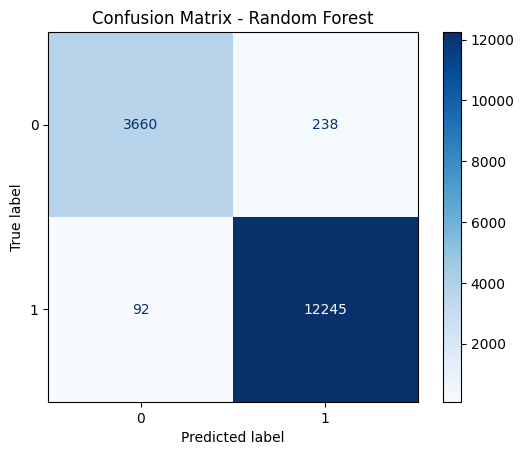

In [517]:

y_pred = res_dt['model'].predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.show()

## **KỊCH BẢN 2**

In [518]:
# Tìm tên cột TTL hay chữ tương tự: thử những biến thể phổ biến
ttl_candidates = [c for c in X_scaled.columns if c.lower().find('ttl')!=-1]
if len(ttl_candidates) == 0:
    # fallback: drop top-1 feature theo corr/importance
    occlusion_feature = fi.index[0]
    print("Không tìm thấy TTL. Sử dụng feature top-1:", occlusion_feature)
else:
    occlusion_feature = ttl_candidates[0]
    occlusion_feature = ttl_candidates[1]
    print("Tìm thấy TTL-like feature:", occlusion_feature)


Tìm thấy TTL-like feature: sttl


In [519]:
print(ttl_candidates)

['ct_state_ttl', 'sttl']


In [520]:
# prepare occluded set
if occlusion_feature in X_test.columns:
    X_test_occ = X_test.drop(columns=[occlusion_feature])
    X_train_occ = X_train.drop(columns=[occlusion_feature])
    # retrain RF on data without that feature (realistic occlusion protocol)
    rf_occ = RandomForestClassifier(n_estimators=100, max_depth=10,random_state=RANDOM_STATE, n_jobs=-1)
    # rf_occ=  DecisionTreeClassifier(max_depth=10,random_state=RANDOM_STATE)
    res_rf_occ = train_and_eval(rf_occ, X_train_occ, y_train, X_test_occ, y_test)
    print("\n[RF after occlusion] drop:", occlusion_feature)
    print("time=%.3fs, acc=%.4f" % (res_rf_occ['train_time_s'], res_rf_occ['accuracy']))
    print("Accuracy giảm tuyệt đối:", res_rf['accuracy'] - res_rf_occ['accuracy'])
    print("Giảm theo %:", (res_rf['accuracy'] - res_rf_occ['accuracy'])/res_rf['accuracy']*100)
else:
    print("Feature occlusion không thực hiện được vì không tồn tại trong X_test cols.")


[RF after occlusion] drop: sttl
time=0.965s, acc=0.9829
Accuracy giảm tuyệt đối: 0.0017246689251616543
Giảm theo %: 0.1751642164529212


In [521]:
# Tìm tên cột TTL hay chữ tương tự: thử những biến thể phổ biến
ttl_candidates = [c for c in X_scaled.columns if c.lower().find('ttl')!=-1]
if len(ttl_candidates) == 0:
    # fallback: drop top-1 feature theo corr/importance
    occlusion_feature = fii.index[0]
    print("Không tìm thấy TTL. Sử dụng feature top-1:", occlusion_feature)
else:
    occlusion_feature = ttl_candidates[0]
    occlusion_feature = ttl_candidates[1]
    print("Tìm thấy TTL-like feature:", occlusion_feature)

Tìm thấy TTL-like feature: sttl


In [522]:
# prepare occluded set
if occlusion_feature in X_test.columns:
    X_test_occ = X_test.drop(columns=[occlusion_feature])
    X_train_occ = X_train.drop(columns=[occlusion_feature])
    
    # retrain RF on data without that feature (realistic occlusion protocol)
    # dt_occ=  DecisionTreeClassifier(max_depth=10,random_state=RANDOM_STATE)
    dt_occ=  DecisionTreeClassifier(max_depth=10,random_state=RANDOM_STATE)
    res_dt_occ = train_and_eval(dt_occ, X_train_occ, y_train, X_test_occ, y_test)
    print("\n[DT after occlusion] drop:", occlusion_feature)
    print("time=%.3fs, acc=%.4f" % (res_dt_occ['train_time_s'], res_dt_occ['accuracy']))
    print("Accuracy giảm tuyệt đối:", res_dt['accuracy'] - res_dt_occ['accuracy'])
    print("Giảm theo %:", (res_dt['accuracy'] - res_dt_occ['accuracy'])/res_dt['accuracy']*100)
else:
    print("Feature occlusion không thực hiện được vì không tồn tại trong X_test cols.")


[DT after occlusion] drop: sttl
time=0.361s, acc=0.9797
Accuracy giảm tuyệt đối: 0.0
Giảm theo %: 0.0


## **KỊCH BẢN 3**

In [523]:
dt = DecisionTreeClassifier(random_state=RANDOM_STATE)
rf_small = RandomForestClassifier(n_estimators=50, random_state=RANDOM_STATE, n_jobs=-1)

res_dt = train_and_eval(dt, X_train, y_train, X_test, y_test)
res_rf_small = train_and_eval(rf_small, X_train, y_train, X_test, y_test)

print("\nComparison summary:")
print("DecisionTree: time=%.3fs, acc=%.4f" % (res_dt['train_time_s'], res_dt['accuracy']))
print("RandomForest(50): time=%.3fs, acc=%.4f" % (res_rf_small['train_time_s'], res_rf_small['accuracy']))



Comparison summary:
DecisionTree: time=0.349s, acc=0.9794
RandomForest(50): time=0.556s, acc=0.9850


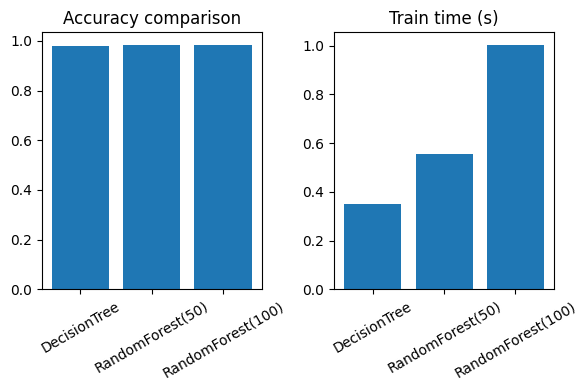

In [524]:
# Bar chart comparison
plt.figure(figsize=(6,4))
models = ['DecisionTree','RandomForest(50)','RandomForest(100)']
accs = [res_dt['accuracy'], res_rf_small['accuracy'], res_rf['accuracy']]
times = [res_dt['train_time_s'], res_rf_small['train_time_s'], res_rf['train_time_s']]

plt.subplot(1,2,1)
plt.bar(models, accs)
plt.xticks(rotation=30)
plt.title('Accuracy comparison')

plt.subplot(1,2,2)
plt.bar(models, times)
plt.xticks(rotation=30)
plt.title('Train time (s)')
plt.tight_layout()
plt.show()

In [525]:
# ---------- Summary print ----------
print("\nFINAL SUMMARY:")
print(f"RF(100) acc={res_rf['accuracy']:.4f}, time={res_rf['train_time_s']:.3f}s")
print(f"RF(50)  acc={res_rf_small['accuracy']:.4f}, time={res_rf_small['train_time_s']:.3f}s")
print(f"DT      acc={res_dt['accuracy']:.4f}, time={res_dt['train_time_s']:.3f}s")
if 'res_rf_occ' in locals():
    print(f"RF after occlusion (drop {occlusion_feature}) acc={res_rf_occ['accuracy']:.4f}, time={res_rf_occ['train_time_s']:.3f}s")


FINAL SUMMARY:
RF(100) acc=0.9846, time=1.004s
RF(50)  acc=0.9850, time=0.556s
DT      acc=0.9794, time=0.349s
RF after occlusion (drop sttl) acc=0.9829, time=0.965s
